# Spotted Python Week 8 Tutorial
In this script, we aim to practice the following skills:
- Fitting a Gaussian
- Determining redshift of a galaxy

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table, join
from scipy.odr import *
from scipy.signal import find_peaks

## Gaussian Fitting
In pervious weeks, we looked at linear fitting. However gaussian fitting is equally common within physics.

### **Example 1:**
Generate simulated spectral line and fit an gaussian

In [2]:
# define a general gaussian function
def gaussian(parameters, x):
    c, A, mu, sigma = parameters
    return c + A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

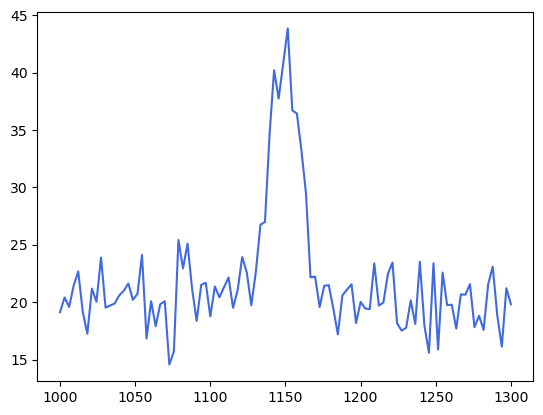

In [4]:
# generate simulated data
x_sim = np.linspace(1000, 1300, 100) # x values
y_sim = gaussian([10,23,1150,10],x_sim)
y_noise = np.random.normal(10,2,y_sim.shape) # add gaussian noise
y_total = y_sim + y_noise # final y_values

# plot simulated data to check shape
plt.plot(x_sim, y_total, color='royalblue')

In [5]:
# Fitting a gaussian to the simulated data
model = Model(gaussian) # making the defined function into a model
# takes the real data and fits it to the model with an initial guess for the parameters
odr = ODR(RealData(x_sim, y_total),
                 model, beta0=[100, 20, 1150, 15])
output = odr.run()
output.pprint()

Beta: [  20.15300895   22.41647501 1149.46988084    9.43659355]
Beta Std Error: [0.23448131 1.39342902 0.82135133 0.75128479]
Beta Covariance: [[ 1.20737939e-02 -8.16170501e-03  1.07122799e-04 -8.95557144e-03]
 [-8.16170501e-03  4.26380181e-01  1.22620421e-02 -1.01536490e-01]
 [ 1.07122799e-04  1.22620421e-02  1.48144398e-01 -2.43212302e-03]
 [-8.95557144e-03 -1.01536490e-01 -2.43212302e-03  1.23947137e-01]]
Residual Variance: 4.553786781994758
Inverse Condition #: 0.00954508964114289
Reason(s) for Halting:
  Sum of squares convergence


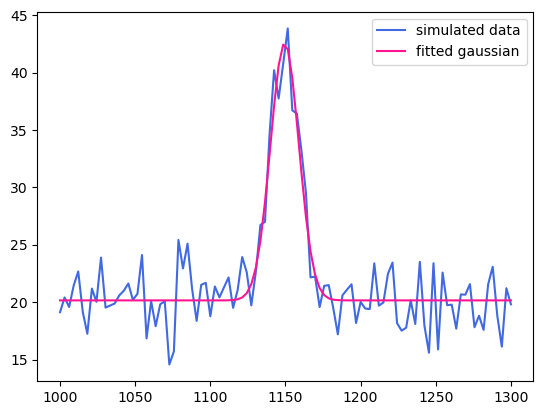

In [6]:
# plot the simulated data with the fitted gaussian
plt.plot(x_sim, y_total, color = 'royalblue', label='simulated data') # orginal data
plt.plot(x_sim, gaussian(output.beta, x_sim), color='deeppink', label ='fitted gaussian')
plt.legend(loc='best') # show legend

### **Excercise 1:**
To practice this fitting, you can use the below space to simulate your own data.

## Spectroscopic Redshift
Recall that redshift can be determined using the following formulae: $$z=\frac{\Delta \lambda}{\lambda_{rest}}=\frac{\lambda_{observed}-\lambda_{rest}}{\lambda_{rest}}\Rightarrow z=\frac{\lambda_{observed}}{\lambda_{rest}}-1,$$ where $\lambda_{rest}$ is the rest frame wavelength, and $\lambda_{observed}$ is the oberserved wavelength in the spectra.

### **Example 2:**
Open NGC0000.fits, extract flux, plot the spectra, and identify any emission/absorption lines. Attempt to fit the line using a gaussian or alternative methods, and determine the redshift of the example spectra

Notes:
- List of spectral lines available [here](http://astronomy.nmsu.edu/drewski/tableofemissionlines.html#:~:text=The%20ultraviolet%20and%20optical%20spectra,nature%20of%20the%20ionizing%20source.)
- $H_{\alpha}$ (6562.819 A) is almost always the highest in flux, so let's identify that first
- To the left of $H_{\alpha}$ is $[NII]6548$ (6548.050 A)
- To the right of $H_{\alpha}$ is $[NII]6583$ (6583.460 A)

In [7]:
# Open fits
data = fits.open('NGC0000.fits')
data.info()

Filename: NGC0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1266   ()      
  1  DATA          1 ImageHDU        42   (30, 30, 3682)   float32   
  2  STAT          1 ImageHDU        43   (30, 30, 3682)   float32   


In [8]:
# Let's have a look at the headers
data['data'].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                   30 / length of data axis 1                          
NAXIS2  =                   30 / length of data axis 2                          
NAXIS3  =                 3682 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

wavelength range: [4750.43408203125 to 9351.68408203125 Angstroms]
flux cube shape: (3682, 30, 30)


Text(0, 0.5, 'Flux, $F$ $[10^{-20} \\AA cm^{-2} erg s^{-1}]$')

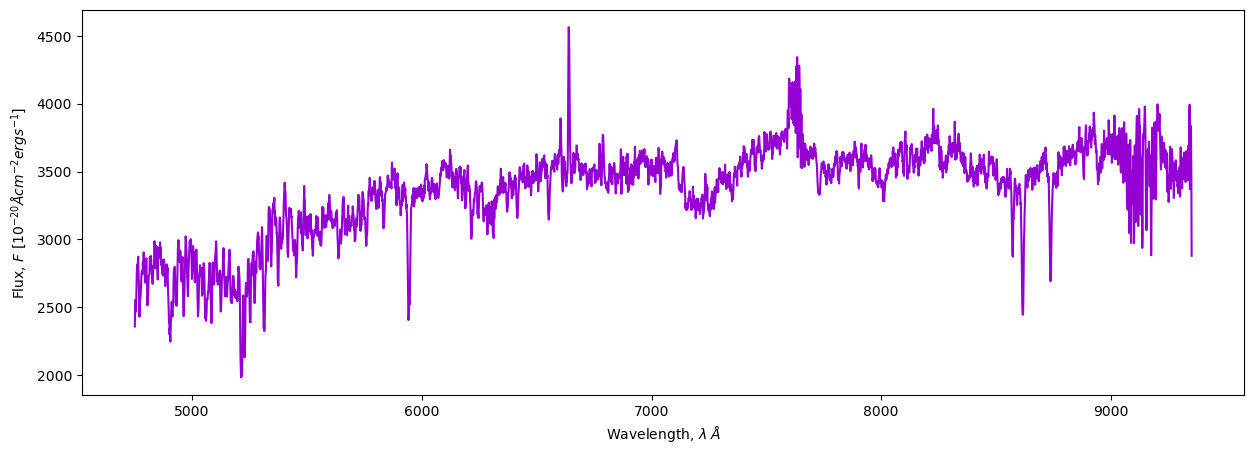

In [9]:
# To get the wavelength, we need to use CRPIX3, CRVAL3, CD3_3, and NAXIS3
crpix3 = data['data'].header['crpix3']
crval3 = data['data'].header['crval3']
cdelt3 = data['data'].header['cd3_3']
naxis3 = data['data'].header['naxis3']

wavelength = crval3 + (np.arange(naxis3) + 1 - crpix3) * cdelt3
print(f"wavelength range: [{wavelength[0]} to {wavelength[-1]} Angstroms]")

cube = data['data'].data
print(f"flux cube shape: {cube.shape}")

# Let's just look at the central pixel
flux = cube[:, 15, 15]

# Plot the spectra
plt.figure(figsize=(15,5))
plt.plot(wavelength, flux, color='darkviolet')
plt.xlabel('Wavelength, $\lambda$ $\\AA$') # x-axis label
plt.ylabel('Flux, $F$ $[10^{-20} \\AA cm^{-2} erg s^{-1}]$') # y-axis label

Text(0, 0.5, 'Flux, $F$ $[10^{-20} \\AA cm^{-2} erg s^{-1}]$')

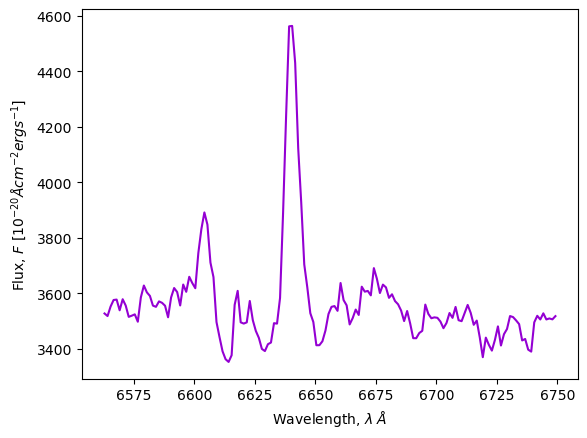

In [10]:
# let's zoom into the wavelength range of interest
wavelength_short = wavelength[1450:1600]
flux_short = flux[1450:1600]
plt.plot(wavelength_short, flux_short, color='darkviolet')
plt.xlabel('Wavelength, $\lambda$ $\\AA$') # x-axis label
plt.ylabel('Flux, $F$ $[10^{-20} \\AA cm^{-2} erg s^{-1}]$') # y-axis label

In [17]:
# define the rest frame wavelengths
h_alpha = 6562.819
nii_1 = 6548.050
nii_2 = 6583.460

# Identify the wavelengths of the spectral lines
peaks, _ = find_peaks(flux_short, height=4000)
print(f"number of peaks: {len(peaks)}")

# define the observed wavelengths
h_alpha_obs = wavelength_short[peaks[0]] # h_alpha
#nii_1_obs = wavelength_short[peaks[0]] # nii 6548.050
#nii_2_obs = wavelength_short[peaks[2]] # nii 6583.460

# Calculate redshift using individual lines
z_1 = h_alpha_obs/h_alpha -1
#z_2 = nii_1_obs/nii_1 -1
#z_3 = nii_2_obs/nii_2 -1
#z_avg = np.mean((z_1,z_2,z_3))
print(f'Spectroscopic redshift is: z= {round(z_1, 4)}') # prints to 4 decimal places

number of peaks: 1
Spectroscopic redshift is: z= 0.009


### **Exercise 2:**
Repeat example 2 with another spectra from the cube, you should get a redshift that is similar (since it is the same galaxy)